##Look at the hourly data

Now on to the real challenge, the hourly data. So, as usual, make some plots, do a bit of anaalysis and try to get a feel for the data.

###Remaining TO DO:
* Try preprocessing - standardizing the features, which I really should do....
* Try one hot encoder with days of the week (each day should be treated as a separate feature instead of a continuous one)
  * When doing this, can get rid of 'working day' feature
* Fit independently to the 'casual' and 'registered' values as targets, and then when we do predict, sum the two predictions to compare to the test values - this is probably only useful/effective for certain estimators
* Plot the predicted heatmap divided by the actual heatmap to see where the estimator is getting it wrong (day vs time plot)
* Clean up the plots and make them look nicer 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
hourly = pd.read_csv('Bike-Sharing-Dataset/hour.csv',header = 0)

In [53]:
hourly.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [39]:
type(hourly)
for row_index, row in hourly.iterrows():
    
    print row_index ,  row['registered']
    if (row_index > 5):
        break


0 13
1 32
2 27
3 10
4 1
5 1
6 0


In [40]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['registered']

In [41]:
print np.max(weekly)

50883.0


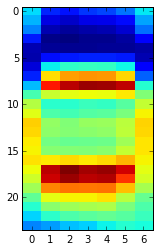

In [42]:
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

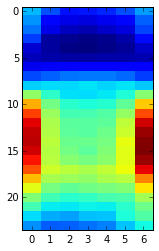

In [43]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['casual']
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

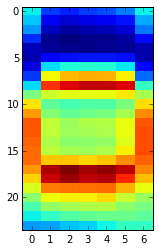

In [44]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['cnt']
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

###It's quite clear that registered and casual users are very different

I already knew this from analyzing the daily data, but this shows that registered riders tend to commute, while casual riders joy ride on the weekends. And, if you look closely, you can see that registered users tend to head out of work a bit earlier on fridays. To get the best model, we'll need to include weekday (which we may want to put through one-hot encoder first).

###Get ready for ML

I want to use the training/test cut that Kaggle does, so need to put the day of the month into the column, and then drop the unnecessary columns

In [54]:
hourly['day'] =  pd.DatetimeIndex(hourly.dteday).day
hourly = hourly.drop(['instant','dteday','casual','registered'], axis = 1)

In [71]:
Xtrain = hourly[hourly.day < 19].drop('cnt',axis=1).values #the data for the training set
ytrain = (hourly[hourly.day < 19])['cnt'].values #the target of the training set

Xtest = hourly[hourly.day >= 19].drop('cnt',axis=1).values #the data for the test set
ytest = (hourly[hourly.day >= 19])['cnt'].values #the target of the test set

In [96]:
print ytrain.shape
print Xtrain.shape
print ytest.shape
print Xtest.shape
print Xtest[0]

(10312,)
(10312, 13)
(7067,)
(7067, 13)
[  1.       0.       1.       0.       0.       3.       1.       2.       0.22
   0.2727   0.93     0.      19.    ]


In [81]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [89]:
cv = cross_validation.ShuffleSplit(len(Xtrain), n_iter=3, test_size=0.2,
    random_state=0)
   
for train, test in cv:    
    reg = RandomForestRegressor(n_estimators = 500).fit(Xtrain[train], ytrain[train])
    print reg.score(Xtrain[train], ytrain[train]), reg.score(Xtrain[test], ytrain[test])
print reg.score(Xtest,ytest)

0.993274648146 0.954023946833
0.993336841454 0.947467825542
0.993102718662 0.949786032363
0.879229855109


In [90]:
estimators = [10,100,500]
grid = GridSearchCV(estimator=reg, param_grid=dict(n_estimators=estimators), n_jobs=-1)
grid.fit(Xtrain,ytrain)        

print grid.best_score_                                  

print grid.best_estimator_.n_estimators         

0.699619273623
100


In [85]:
print grid.grid_scores_

[mean: 0.69401, std: 0.12695, params: {'n_estimators': 10}, mean: 0.69839, std: 0.12730, params: {'n_estimators': 100}, mean: 0.69949, std: 0.12884, params: {'n_estimators': 500}, mean: 0.69979, std: 0.12862, params: {'n_estimators': 1000}]


RandomForestRegressor does a much better job than the other estimators. Not seeing much difference when I change n_estimators, and the mean score is much lower than I'd expect (ie, it doesn't match the cv scores above). I wonder if I did this right ....


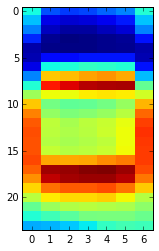

In [105]:
pred = reg.predict(Xtest) #put the predicted values into an array
hrInd=3 #the column number of the hr column
weekdayInd = 5 
weekly = np.zeros((24,7))
for i in range(0,len(ytest)):
    weekly[Xtest[i,hrInd], Xtest[i,weekdayInd]] += pred[i]
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

#LEFT OFF HERE -

this is the predicted heatmap. divide it by the actual heatmaps to see where we were wrong